In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import random
import time
from collections import deque

%matplotlib inline

In [3]:
# データの読み込み
# 枝確率を計算済みのネットワークを読み込む
network = pd.read_csv("data.csv")
network.head()

,# FromNodeId,ToNodeId,p
0,0,4,0.008000
1,0,5,0.005682
2,0,7,0.033333
3,0,8,0.009615
4,0,9,0.066667


In [4]:
# numpy型に変換
network_np = network.values

In [5]:
# 空の有向グラフを作成
G = nx.DiGraph()

In [6]:
# 重み付きの枝を加える
G.add_weighted_edges_from(network_np)

In [50]:
# 入力は隣接リスト(numpy)[[from_node, to_node, edge_prob],...]
def live_edge_graph_edges(p, p_len):
    rand = np.random.uniform(0, 1, p_len)
    return np.array([[p[i][0], p[i][1]] for i in range(p_len) if rand[i] < p[i][2]])

In [21]:
%time simulation = live_edge_graph_edges(network_np, len(network_np))

0.6661914204751673
CPU times: user 461 ms, sys: 11.6 ms, total: 473 ms
Wall time: 500 ms


In [22]:
simulation

array([[0.0000e+00, 2.6000e+01],
       [0.0000e+00, 1.1400e+02],
       [0.0000e+00, 7.9900e+02],
       ...,
       [7.5869e+04, 7.5868e+04],
       [7.5876e+04, 7.5877e+04],
       [7.5887e+04, 5.2098e+04]])

In [64]:
def reach_node_size(live_edge, seed):
    # グラフ作成
    H = nx.DiGraph()
    H.add_edges_from(live_edge)
    
    # 到達可能な頂点集合をシードごとに和集合して求める
    reach_set = set([])
    for s in seed:
        # たどり着いているノードがシードでない場合だけ計算する
        if s not in reach_set:
            try:
                reach_set |= set(nx.dfs_preorder_nodes(H,source=s))
            except:
                return H
    return len(reach_set)

In [65]:
%time reach_node_size(simulation, [0])

CPU times: user 791 ms, sys: 31 ms, total: 822 ms
Wall time: 824 ms


44

In [73]:
# 影響数の期待値(近似)
# approxim_expected_influence_num(枝確率, シード, ε, δ)
def approx_expect_inf_size(p, seed, epsi, delta):
    # グラフの作成
    G = nx.DiGraph()
    G.add_weighted_edges_from(p)
    
    # 頂点数
    n = G.number_of_nodes()
    
    # 試行回数を算出する
    T = int(((n**2) / (epsi**2)) * np.log(1/delta)) + 1
        
    # 各回のシュミレーションの結果の和が格納される
    X = 0
    len_p = len(p)
    # T回シュミレーションしていく
    for i in tqdm(range(T)):
        # live_edgeグラフを作る
        live_edge = live_edge_graph_edges(p, len_p)
        try:
            X += reach_node_size(live_edge, seed)
        except:
            return reach_node_size(live_edge, seed)
    expected_num = X / T
    return expected_num

In [67]:
# シュミレーションの結果的に変化していない場合は、回数を減らす関数
# 影響数の期待値(近似)
# approxim_expected_influence_num(枝確率, シード, ε, δ, 変化数)
def approx_expect_inf_size_heuris(p, seed, epsi, delta, change):
    # グラフの作成
    G = nx.DiGraph()
    G.add_weighted_edges_from(p)
    
    # 頂点数
    n = G.number_of_nodes()
    
    # 試行回数を算出する
    T = int(((n**2) / (epsi**2)) * np.log(1/delta)) + 1
        
    # 各回のシュミレーションの結果の和が格納される
    X = 0
    len_p = len(p)
    # T回シュミレーションしていく
    for i in tqdm(range(T)):
        # live_edgeグラフを作る
        live_edge = live_edge_graph_edges(p, len_p)
        X += reach_node_size(live_edge, seed)
        
        # 前回と比較して変化なし
        # if (i != 0) and (abs(((X / (i+1)) - expected_num) / expected_num) < rate_change):
        if (i != 0) and (abs(((X / (i+1)) - expected_num) < change)):    
            return expected_num
        
        expected_num = X / (i+1)
    return expected_num

In [68]:
# 幅優先探索
# アルゴリズム by https://todo314.hatenadiary.org/entry/20151013/1444720166

In [69]:
def IC_simulation(G, S):
    visited = {s:None for s in S}
    queue = deque(S)
    while queue:
        v = queue.popleft()
        out_node = G[v]
        for u in out_node:
            if not (u in visited):
                coin = np.random.uniform(0,1)
                if G[v][u]["weight"] > coin:
                    queue.append(u)
                    visited[u] = v
    return visited

In [70]:
def approx_expected_inf_size_IC(G, seed, epsi, delta):
    # 試行回数を算出する
    n = G.number_of_nodes()
    T = int(((n**2) / (epsi**2)) * np.log(1/delta)) + 1
    inf_size = sum([len(IC_simulation(G, seed)) for i in range(T)])
    return inf_size / T

In [121]:
def approx_expected_inf_size_IC_T(G, seed, T):
    # 試行回数を算出する
    n = G.number_of_nodes()
    inf_size = sum([len(IC_simulation(G, seed)) for i in range(T)])
    return inf_size / T

# 実行時間実験

In [119]:
epsi = 0.9999
delta = 0.9
seed = [0,3]
n = G.number_of_nodes()
int(((n**2) / (epsi**2)) * np.log(1/delta)) + 1

606747434

In [120]:
# %time approx_expected_inf_size_IC(G, seed, epsi, delta)

In [159]:
time_list = []
x_cnt = []
result = []
seed = [0,5]
sum_inf = 0
T = 100

for t in tqdm(range(1000)):
    start = time.time()
    sum_inf += sum([len(IC_simulation(G, seed)) for i in range(T)])
    time_list.append(time.time() - start)
    result.append(sum_inf / (T*(t+1)))
    x_cnt.append(T*(t+1))

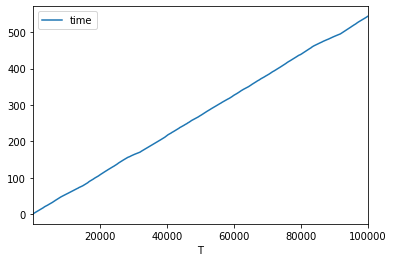

In [160]:
time_df = pd.DataFrame({"T":x_cnt, "time":np.cumsum(time_list)}).set_index("T")
time_df.plot()
plt.show()

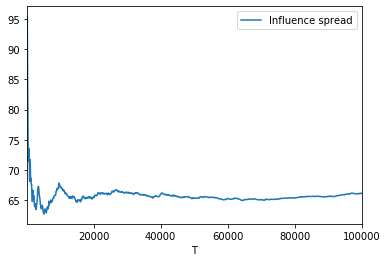

In [161]:
inf_df = pd.DataFrame({"T":x_cnt, "Influence spread":result}).set_index("T")
inf_df.plot()
plt.show()